In [71]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import requests, time, math
import numpy as np
from datetime import date, timedelta, datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

latest_date=(date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
nations={"England":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "N. Ireland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=N92000002&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "Scotland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=S92000003&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "Wales":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=W92000004&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv"}
population={"England":56286961,
             "N. Ireland":1893700,
             "Scotland":5463300,
             "Wales":3152879}
threshold={"hospital":0,
           "deaths":3,
           "cases":3}
cutoff_date=(date.today() - timedelta(days=threshold[min(threshold)])).strftime("%Y-%m-%d")
average_period=7
load_new=False

Area Codes:
    England - E92000001
    N. Ireland - E92000002
    Scotland - E92000003
    Wales - E92000004

In [72]:
data={k:[] for k in nations.keys()}
for name,url in nations.items():
    if load_new==True:
        f = requests.get(url)
        with open("%s.csv"%(name),"w+") as out:
            out.seek(0)
            out.write(f.text)
            out.truncate()
    data[name]=pd.read_csv("%s.csv"%name)
    data[name]=data[name].drop(["areaType","areaCode","areaName"],axis=1)
    data[name]=data[name].rename(columns={'newAdmissions':'hospital',"newCasesBySpecimenDate":"cases","newDeaths28DaysByDeathDate":"deaths"})
    data[name].date=pd.to_datetime(data[name].date)
    for metric in ["hospital","cases","deaths"]:
        data[name][metric]=data[name][metric][threshold[metric]:]
        data[name][metric]=data[name][metric].rolling(window=average_period, min_periods=1).mean()
    data[name]=data[name].apply(lambda x: x/(population[name]/100000) if x.name in ["cases","deaths","hospital"] else x,  axis = 0)
    #data[name]=data[name].iloc[threshold:]

In [73]:
def errorbar(x,pm,both=True):
    pm=math.ceil(pm)
    x = datetime.strptime(x, "%Y-%m-%d")
    if both==True:
        l = x - timedelta(days = pm) 
    else:
        l=x
    r = x + timedelta(days = pm) 
    return [l,r]

In [87]:
def plot(nations=["England","Wales"],metrics=["deaths","cases","hospital"],start_date=None,lockdowns=False):
    plt.rcParams["figure.figsize"] = (10,8)
    fig,ax=plt.subplots()
    ax2=ax.twinx()
    for metric in metrics:
        for nation in nations:
            if metric=="cases":
                ax.plot(data[nation]["date"],data[nation][metric],label="%s - %s"%(nation,metric))
            else:
                ax2.plot(data[nation]["date"],data[nation][metric],label="%s - %s"%(nation,metric),linestyle="--")
    if start_date!=None:
        plt.xlim(xmin=start_date)
    plt.xlim(xmax=cutoff_date)
    ax.errorbar([0],[0],marker="x",color="black",label="Lockdown Start")
    ax.errorbar([0],[0],marker="x",color="grey",label="Tier System Start")
    ax2.errorbar([0],[0],marker="o",color="black",label="Lockdown plus $18.5\pm3.5$ days")
    ax2.errorbar([0],[0],marker="o",color="grey",label="Tier System plus $18.5\pm3.5$days")
    if lockdowns==True:
        if "Wales" in nations:
            if "cases" in metrics:
                ax.scatter("2020-10-23",data["Wales"].loc[data["Wales"]['date'] == "2020-10-23"]["cases"],marker="x",color="black")
                ax.plot(errorbar("2020-10-23",2,both=False),[data["Wales"].loc[data["Wales"]['date'] == "2020-10-23"]["cases"].values,data["Wales"].loc[data["Wales"]['date'] == "2020-10-23"]["cases"].values],color="black")
                ax.scatter("2020-12-25",data["Wales"].loc[data["Wales"]['date'] == "2020-12-25"]["cases"],marker="x",color="black")
                ax.plot(errorbar("2020-12-25",2,both=False),[data["Wales"].loc[data["Wales"]['date'] == "2020-12-25"]["cases"].values,data["Wales"].loc[data["Wales"]['date'] == "2020-12-25"]["cases"].values],color="black")
            if "deaths" in metrics:
                ax2.scatter(["2020-11-10"],data["Wales"].loc[data["Wales"]['date'] == "2020-11-10"]["deaths"].values,marker="o",color="black")
                ax2.plot(errorbar("2020-11-10",3.5),[data["Wales"].loc[data["Wales"]['date'] == "2020-11-10"]["deaths"].values,data["Wales"].loc[data["Wales"]['date'] == "2020-11-10"]["deaths"].values],color="black")
            if start_date==None:
                if "hospital" in metrics:
                    ax2.scatter("2020-03-23",data["Wales"].loc[data["Wales"]['date'] == "2020-03-23"]["hospital"],marker="x",color="black")
                if "cases" in metrics:
                    ax.scatter("2020-03-23",data["Wales"].loc[data["Wales"]['date'] == "2020-03-23"]["cases"],marker="x",color="black")
                if "deaths" in metrics:
                    ax2.scatter(["2020-04-10"],data["Wales"].loc[data["Wales"]['date'] == "2020-04-10"]["deaths"].values,marker="o",color="black")
                    ax2.plot(errorbar("2020-04-10",3.5),[data["Wales"].loc[data["Wales"]['date'] == "2020-04-10"]["deaths"].values,data["Wales"].loc[data["Wales"]['date'] == "2020-04-10"]["deaths"].values],color="black")
            elif int(start_date[5:7])<=3:
                if "hospital" in metrics:
                    ax2.scatter("2020-03-23",data["Wales"].loc[data["Wales"]['date'] == "2020-03-23"]["hospital"],marker="x",color="black")
                if "cases" in metrics:
                    ax.scatter("2020-03-23",data["Wales"].loc[data["Wales"]['date'] == "2020-03-23"]["cases"],marker="x",color="black")
                if "deaths" in metrics:
                    ax2.scatter(["2020-04-10"],data["Wales"].loc[data["Wales"]['date'] == "2020-04-10"]["deaths"].values,marker="o",color="black")
                    ax2.plot(errorbar("2020-04-10",3.5),[data["Wales"].loc[data["Wales"]['date'] == "2020-04-10"]["deaths"].values,data["Wales"].loc[data["Wales"]['date'] == "2020-04-10"]["deaths"].values],color="black")
        if "England" in nations:
            if "cases" in metrics:
                ax.scatter("2020-12-25",data["England"].loc[data["England"]['date'] == "2020-12-25"]["cases"],marker="x",color="grey")
                ax.plot(errorbar("2020-12-25",2,both=False),[data["England"].loc[data["England"]['date'] == "2020-12-25"]["cases"].values,data["England"].loc[data["England"]['date'] == "2020-12-25"]["cases"].values],color="grey")
                ax.scatter("2020-11-05",data["England"].loc[data["England"]['date'] == "2020-11-05"]["cases"],marker="x",color="black")
                ax.plot(errorbar("2020-11-05",2,both=False),[data["England"].loc[data["England"]['date'] == "2020-11-05"]["cases"].values,data["England"].loc[data["England"]['date'] == "2020-11-05"]["cases"].values],color="black")
                ax.scatter("2020-10-13",data["England"].loc[data["England"]["date"]=="2020-10-13"]["cases"],marker="x", color="grey")
            if "deaths" in metrics:
                ax2.scatter(["2020-10-31"],data["England"].loc[data["England"]['date'] == "2020-10-31"]["deaths"].values,marker="o",color="grey")
                ax2.plot(errorbar("2020-10-31",3.5),[data["England"].loc[data["England"]['date'] == "2020-10-31"]["deaths"].values,data["England"].loc[data["England"]['date'] == "2020-10-31"]["deaths"].values],color="grey")
                ax2.scatter(["2020-11-23"],data["England"].loc[data["England"]['date'] == "2020-11-23"]["deaths"].values,marker="o",color="black")
                ax2.plot(errorbar("2020-11-23",3.5),[data["England"].loc[data["England"]['date'] == "2020-11-23"]["deaths"].values,data["England"].loc[data["England"]['date'] == "2020-11-23"]["deaths"].values],color="black")
            if start_date==None:
                if "hospital" in metrics:
                    ax2.scatter("2020-03-23",data["England"].loc[data["England"]['date'] == "2020-03-23"]["hospital"],marker="x",color="black")
                if "cases" in metrics:
                    ax.scatter("2020-03-23",data["England"].loc[data["England"]['date'] == "2020-03-23"]["cases"],marker="x",color="black")
                if "deaths" in metrics:
                    ax2.scatter(["2020-04-10"],data["England"].loc[data["England"]['date'] == "2020-04-10"]["deaths"].values,marker="o",color="black")
                    ax2.plot(errorbar("2020-04-10",3.5),[data["England"].loc[data["England"]['date'] == "2020-04-10"]["deaths"].values,data["England"].loc[data["England"]['date'] == "2020-04-10"]["deaths"].values],color="black")
            elif int(start_date[5:7])<=3:
                if "hospital" in metrics:
                    ax2.scatter("2020-03-23",data["England"].loc[data["England"]['date'] == "2020-03-23"]["hospital"],marker="x",color="black")
                if "cases" in metrics:
                    ax.scatter("2020-03-23",data["England"].loc[data["England"]['date'] == "2020-03-23"]["cases"],marker="x",color="black")
                if "deaths" in metrics:
                    ax2.scatter(["2020-04-10"],data["England"].loc[data["England"]['date'] == "2020-04-10"]["deaths"].values,marker="o",color="black")
                    ax2.plot(errorbar("2020-04-10",3.5),[data["England"].loc[data["England"]['date'] == "2020-04-10"]["deaths"].values,data["England"].loc[data["England"]['date'] == "2020-04-10"]["deaths"].values],color="black")
        if "Scotland" in nations:
            if start_date==None:
                if "cases" in metrics:
                    ax.scatter("2020-03-23",data["Scotland"].loc[data["Scotland"]['date'] == "2020-03-23"]["cases"],marker="x",color="black")
                if "deaths" in metrics:
                    ax2.scatter(["2020-04-10"],data["Scotland"].loc[data["Scotland"]['date'] == "2020-04-10"]["deaths"].values,marker="o",color="black")
                    ax2.plot(errorbar("2020-04-10",3.5),[data["Scotland"].loc[data["Scotland"]['date'] == "2020-04-10"]["deaths"].values,data["Scotland"].loc[data["Scotland"]['date'] == "2020-04-10"]["deaths"].values],color="black")
            elif int(start_date[5:7])<=3:
                if "cases" in metrics:
                    ax.scatter("2020-03-23",data["Scotland"].loc[data["Scotland"]['date'] == "2020-03-23"]["cases"],marker="x",color="black")
                if "deaths" in metrics:
                    ax2.scatter(["2020-04-10"],data["Scotland"].loc[data["Scotland"]['date'] == "2020-04-10"]["deaths"].values,marker="o",color="black")
                    ax2.plot(errorbar("2020-04-10",3.5),[data["Scotland"].loc[data["Scotland"]['date'] == "2020-04-10"]["deaths"].values,data["Scotland"].loc[data["Scotland"]['date'] == "2020-04-10"]["deaths"].values],color="black")
    if "cases" in metrics:
        ax.legend()
    if "deaths" in metrics:
        ax2.legend()
    ax.set_ylabel("Per 100k")
    ax2.set_ylabel("Deaths per 100k")
    ax.set_xlabel("Date")
        

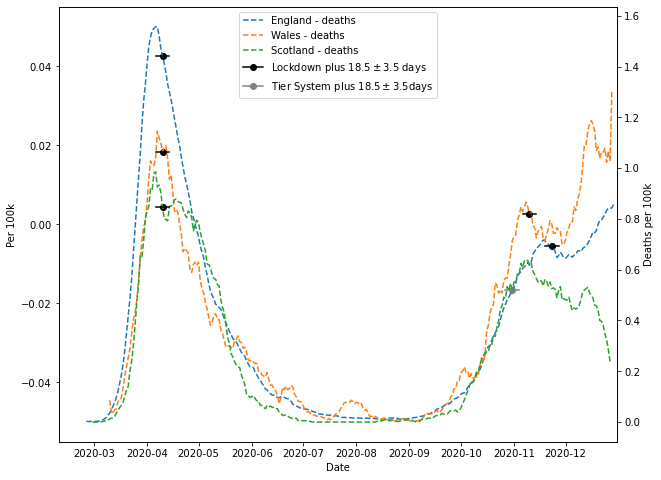

In [88]:
plot(lockdowns=True,metrics=["deaths"],nations=["England","Wales","Scotland"])

Lockdowns seem to always cause a drop in deaths $18.5\pm3.5$ days after they begin (in England and Wales, Scotland tends to react after the lockdown is announced) as supported by [1]. 

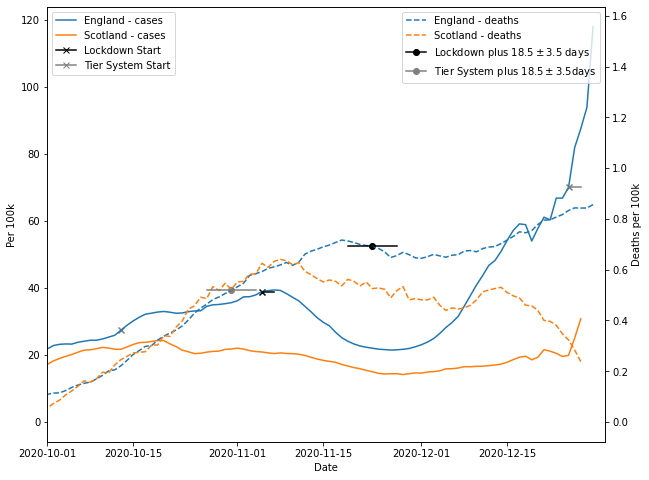

In [91]:
plot(lockdowns=True,metrics=["deaths","cases"],nations=["England","Scotland"],start_date="2020-10-01")

The second lockdown in both England and Wales caused a drop in cases 2 days after they began. This appears to be happening in Wales but not in response to the new England tier system.

The first lockdown can't tell us anything about the response of cases to lockdown because almost none were being counted to it would be expected to carry on going up as testing/diagnosis increased. 

Scotland on the other hand have a functioning tier system right from the begining including boarder closures - proven to be effective NPIs[2] - if the time from the announcement is also plotted.

Hospitalisations went down 3 days after the first lockdown began in Wales and about 6 days later in England. We should see a response from christmas when full data is out for the very end of January (hospitalisaiton data has the shortest lag in reporting of about a day).

[1]https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3

[2]https://www.nature.com/articles/s41562-020-01009-0